# Data analysis and cleaning
In this notebook, we load in datasets that we downloaded from different sources, clean up the information they contain, and combine them all together into a csv file.

We also included some data analysis we did, specifically some graphs.

## Preparation

In [9]:
# Library imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [47]:
# Defines all utility functions
DATA_PATH = Path.cwd().parent / 'data'

HELPER_DATETIME_COL = 'datetime'
def format_datetime_range_to_datetime_function_creator(dt_range_label: str):
    def helper_function(df: pd.DataFrame) -> pd.DataFrame:
        df['start_time'] = df[dt_range_label].str.split(' - ', n=1).str[0]
        df['end_time'] = df[dt_range_label].str.split(' - ', n=1).str[1]
    
        df['start_time'] = df['start_time'].str.replace(r'\s*\((?:CEST|CET)\)\s*$', '', regex=True)
        df['end_time'] = df['end_time'].str.replace(r'\s*\((?:CEST|CET)\)\s*$', '', regex=True)
    
        df['start_time'] = pd.to_datetime(df['start_time'], dayfirst=True)
        df['end_time'] = pd.to_datetime(df['end_time'], dayfirst=True)

        # we can either return the start_time or end_time of the range as datetime.
        # here we choose to return the end_time

        df[HELPER_DATETIME_COL] = df['end_time']
        df = df.drop(columns=['start_time', 'end_time'])
        return df

    return helper_function

def load_data(file_name: str, datetime_col: str, timezone: str, extra_pre_processing = None) -> pd.DataFrame:
    df = pd.read_csv(DATA_PATH / file_name)
    if extra_pre_processing:
        df = extra_pre_processing(df)

    # Read the datetime and convert it to UTC timezone if necessary
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['datetime_utc'] = (
        df[datetime_col]
        .dt.tz_localize(timezone, ambiguous='NaT', nonexistent='shift_forward')
        .dt.tz_convert('UTC')
    )
    
    return df

def reduce_data(df: pd.DataFrame, num_entries_per_day: int) -> pd.DataFrame:
    # Filter the dataset to only a certain number of entries per day
    hours_between_selected = 24 / num_entries_per_day
    df_reduced = df[(df['datetime_utc'].dt.hour % hours_between_selected == 0) & (df['datetime_utc'].dt.minute == 0)]
    return df_reduced

def merge_data_sources(df1: pd.DataFrame, df2: pd.DataFrame, merge_col: str = 'datetime_utc', merge_strategy='left') -> pd.DataFrame:
    return df1.merge(df2, on='datetime_utc', how=merge_strategy)

## Load data in

In [37]:
# Load the actual data
df_actual_price = load_data('imbalance_actual.csv', datetime_col='datetime_utc', timezone='UTC')
df_actual_price = df_actual_price.drop(columns=['date', 'hour', 'minute'])
print(f'Loaded actual data with shape {df_actual_price.shape}', end='\n\n')

# Load the forecast data
df_forecasted_price = load_data('imbalance_forecast.csv', datetime_col='datetime_utc', timezone='UTC')
df_forecasted_price['forecasted_price_eur_mwh'] = df_forecasted_price['price_eur_mwh']
df_forecasted_price = df_forecasted_price.drop(columns=['date', 'hour', 'minute', 'second', 'price_eur_mwh'])
print(f'Loaded forecast data with shape {df_forecasted_price.shape}', end='\n\n')

# Load the weather data
df_weather_quarter_hourly = load_data('weather_data-quarter_hourly.csv', datetime_col='time', timezone='Europe/Berlin')
df_weather_quarter_hourly = df_weather_quarter_hourly.drop(columns=['time'])
print(f'Loaded quarter-hourly weather data with shape {df_weather_quarter_hourly.shape}', end='\n\n')
df_weather_hourly = load_data('weather_data-hourly.csv', datetime_col='time', timezone='Europe/Berlin')
df_weather_hourly = df_weather_hourly.drop(columns=['time'])
print(f'Loaded hourly weather data with shape {df_weather_hourly.shape}', end='\n\n')

# Load the total load and day-ahead load data
df_load = load_data('GUI_TOTAL_LOAD_DAYAHEAD_202510132200-202510202200.csv', datetime_col=HELPER_DATETIME_COL, timezone='Europe/Berlin', 
                    extra_pre_processing=format_datetime_range_to_datetime_function_creator('MTU (CET/CEST)'))
df_load = df_load.drop(columns=['MTU (CET/CEST)', 'Area', 'datetime'])
print(f'Loaded total load and day-ahead load data with shape {df_load.shape}', end='\n\n')

# Load the cross-border energy flow data
df_crossborder = load_data('GUI_NET_CROSS_BORDER_PHYSICAL_FLOWS_202510162200-202510172200.csv', datetime_col=HELPER_DATETIME_COL, timezone='Europe/Berlin', 
                    extra_pre_processing=format_datetime_range_to_datetime_function_creator('MTU'))
mask = df_crossborder['Out Area'] == 'Belgium (BE)'
df_crossborder.loc[mask, 'Physical Flow (MW)'] = -df_crossborder.loc[mask, 'Physical Flow (MW)']
df_crossborder = df_crossborder.groupby('datetime_utc', as_index=False)['Physical Flow (MW)'].sum()
print(f'Loaded total load and day-ahead load data with shape {df_load.shape}', end='\n\n')

Loaded actual data with shape (49559, 2)

Loaded forecast data with shape (105949, 2)

Loaded quarter-hourly weather data with shape (50400, 13)

Loaded hourly weather data with shape (12600, 3)

Loaded total load and day-ahead load data with shape (672, 3)

Loaded total load and day-ahead load data with shape (672, 3)



## Combine all data together and export it

In [38]:
# Combine all data together
merge_df = df_actual_price.merge(
    df_forecasted_price, on='datetime_utc', how='left'
).merge(
    df_weather_quarter_hourly, on='datetime_utc', how='left'
).merge(
    df_weather_hourly, on='datetime_utc', how='left'
).merge(
    df_load, on='datetime_utc', how='left'
).merge(
    df_crossborder, on='datetime_utc', how='left'
)
merge_df

# Save to data folder
merge_df.to_csv(DATA_PATH / 'full_data.csv')

# Show the merged data
merge_df

,datetime_utc,price_eur_mwh,forecasted_price_eur_mwh,temperature_2m (°C),rain (mm),snowfall (cm),snowfall_height (m),sunshine_duration (s),wind_speed_10m (km/h),direct_normal_irradiance (W/m²),direct_normal_irradiance_instant (W/m²),precipitation (mm),weather_code (wmo code),is_day (),relative_humidity_2m (%),surface_pressure (hPa),cloud_cover (%),Actual Total Load (MW),Day-ahead Total Load Forecast (MW),Physical Flow (MW)
0,2024-05-21 22:00:00+00:00,106.39,NaN,13.9,0.0,0.0,2320.0,0.0,10.8,0.0,0.0,0.0,3.0,0.0,94.0,1003.3,100.0,NaN,NaN,NaN
1,2024-05-21 22:15:00+00:00,149.28,NaN,13.9,0.0,0.0,2280.0,0.0,11.3,0.0,0.0,0.0,3.0,0.0,93.0,NaN,NaN,NaN,NaN,NaN
2,2024-05-21 22:30:00+00:00,151.17,NaN,13.8,0.0,0.0,2250.0,0.0,11.8,0.0,0.0,0.0,3.0,0.0,93.0,NaN,NaN,NaN,NaN,NaN
3,2024-05-21 22:45:00+00:00,226.60,NaN,13.6,0.0,0.0,2210.0,0.0,12.3,0.0,0.0,0.0,3.0,0.0,93.0,NaN,NaN,NaN,NaN,NaN
4,2024-05-21 23:00:00+00:00,204.76,NaN,13.5,0.0,0.0,2170.0,0.0,12.2,0.0,0.0,0.0,3.0,0.0,93.0,1002.7,100.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49563,2025-10-20 02:30:00+00:00,-56.90,-3.24,15.2,0.0,0.0,2480.0,0.0,18.4,0.0,0.0,0.0,3.0,0.0,90.0,NaN,NaN,7107.38,7315.45,NaN
49564,2025-10-20 02:45:00+00:00,94.02,-100.00,15.1,0.0,0.0,2410.0,0.0,18.0,0.0,0.0,0.0,3.0,0.0,90.0,NaN,NaN,7055.11,7279.60,NaN
49565,2025-10-20 03:00:00+00:00,103.56,96.07,15.1,0.0,0.0,2340.0,0.0,18.0,0.0,0.0,0.0,3.0,0.0,90.0,995.3,100.0,7112.01,7193.42,NaN
49566,2025-10-20 03:15:00+00:00,93.99,93.99,15.1,0.0,0.0,2260.0,0.0,17.6,0.0,0.0,0.0,3.0,0.0,90.0,NaN,NaN,7224.79,7533.46,NaN


## Data analysis

In [53]:
def plot_single_series(df: pd.DataFrame, x_col: str, y_col: str, x_label: str = None, y_label: str = None, graph_title: str = None):
    if not x_label:
        x_label = x_col
    if not y_label:
        y_label = y_col
    
    df_without_na = df.dropna(subset=[x_col, y_col])
    x = df_without_na[x_col]
    y = df_without_na[y_col]
    
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.xticks(rotation=45)
    plt.ylabel(y_label)
    if graph_title: plt.title(graph_title)
    plt.show()

def plot_two_y_series(df: pd.DataFrame, x_col: str, y1_col: str, y2_col: str, 
                       x_label: str = None, y1_label: str = None, y2_label: str = None):
    if not x_label:
        x_label = x_col
    if not y1_label:
        y1_label = y1_col
    if not y2_label:
        y2_label = y2_col
    
    df_without_na = df.dropna(subset=[x_col, y1_col, y2_col])
    x = df_without_na[x_col]
    y1 = df_without_na[y1_col]
    y2 = df_without_na[y2_col]
    
    fig, ax1 = plt.subplots()
    plt.xticks(rotation=45)
    
    ax1.plot(x, y1, color='blue')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label)
    
    ax2 = ax1.twinx()
    ax2.plot(x, y2, color='orange')
    ax2.set_ylabel(y2_label)
    
    plt.show()

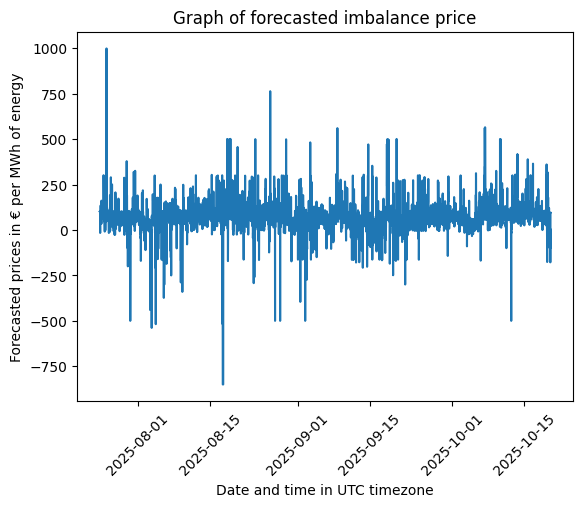

In [50]:
plot_single_series(merge_df, 
                   x_col='datetime_utc', y_col='forecasted_price_eur_mwh', 
                   x_label='Date and time in UTC timezone', y_label='Forecasted prices in € per MWh of energy',
                   graph_title='Graph of forecasted imbalance price'
                  )

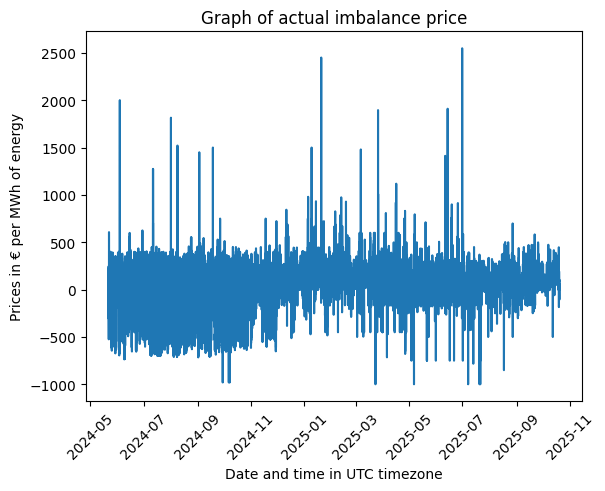

In [66]:
plot_single_series(merge_df, 
                   x_col='datetime_utc', y_col='price_eur_mwh', 
                   x_label='Date and time in UTC timezone', y_label='Prices in € per MWh of energy',
                   graph_title='Graph of actual imbalance price'
                  )

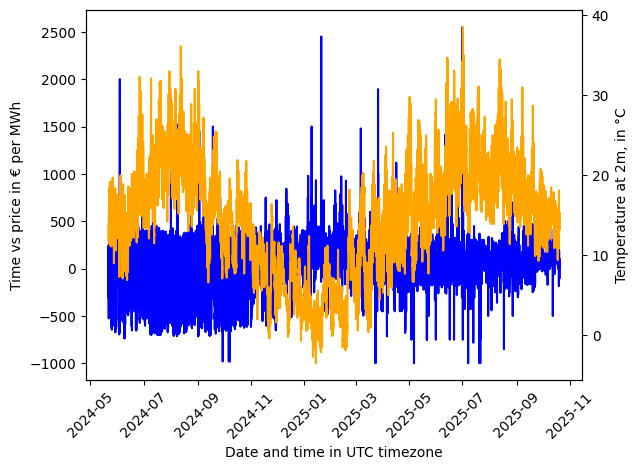

In [67]:
plot_two_y_series(merge_df, 
                  x_col='datetime_utc', y1_col='price_eur_mwh', y2_col='temperature_2m (°C)', 
                  x_label='Date and time in UTC timezone', y1_label='Time vs price in € per MWh', y2_label='Temperature at 2m, in °C')
# hard to tell on such a long timespan if there is a correlation

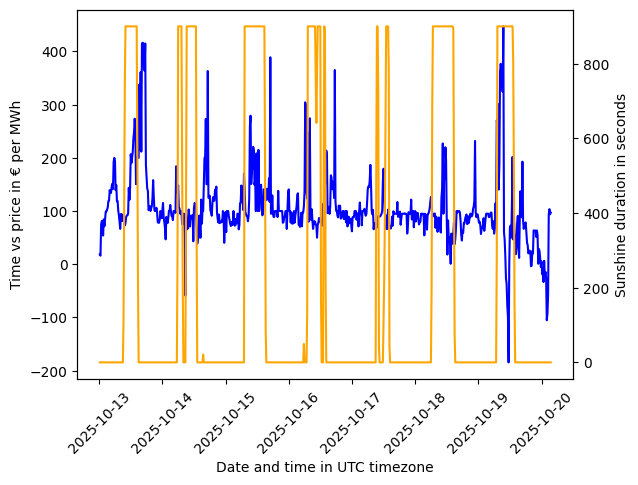

In [68]:
threshold_date = pd.Timestamp('2025-10-13T00:00', tz='UTC')
plot_two_y_series(merge_df[merge_df['datetime_utc'] > threshold_date],
                  x_col='datetime_utc', y1_col='price_eur_mwh', y2_col='sunshine_duration (s)', 
                  x_label='Date and time in UTC timezone', y1_label='Time vs price in € per MWh', y2_label='Sunshine duration in seconds')
# seems partly related, but also very much all or nothing

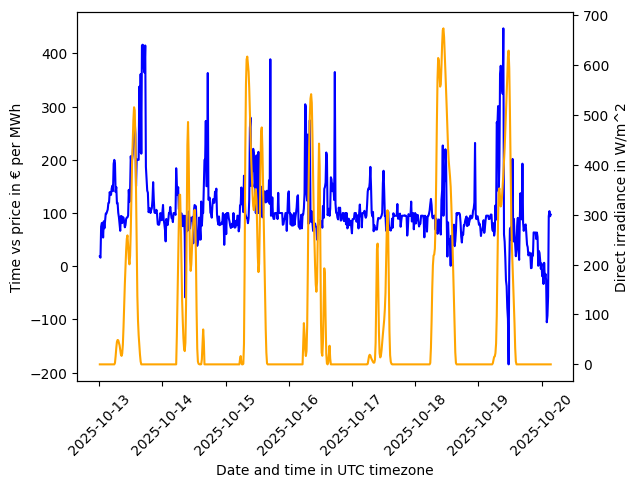

In [69]:
threshold_date = pd.Timestamp('2025-10-13T00:00', tz='UTC')
plot_two_y_series(merge_df[merge_df['datetime_utc'] > threshold_date],
                  x_col='datetime_utc', y1_col='price_eur_mwh', y2_col='direct_normal_irradiance (W/m²)', 
                  x_label='Date and time in UTC timezone', y1_label='Time vs price in € per MWh', y2_label='Direct irradiance in W/m^2')
# seems somewhat correlated

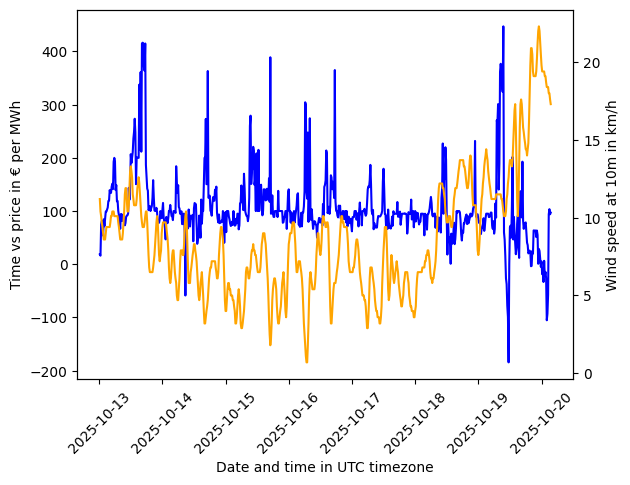

In [70]:
threshold_date = pd.Timestamp('2025-10-13T00:00', tz='UTC')
plot_two_y_series(merge_df[merge_df['datetime_utc'] > threshold_date],
                  x_col='datetime_utc', y1_col='price_eur_mwh', y2_col='wind_speed_10m (km/h)', 
                  x_label='Date and time in UTC timezone', y1_label='Time vs price in € per MWh', y2_label='Wind speed at 10m in km/h')
# --> will need to be checked on a larger timespan

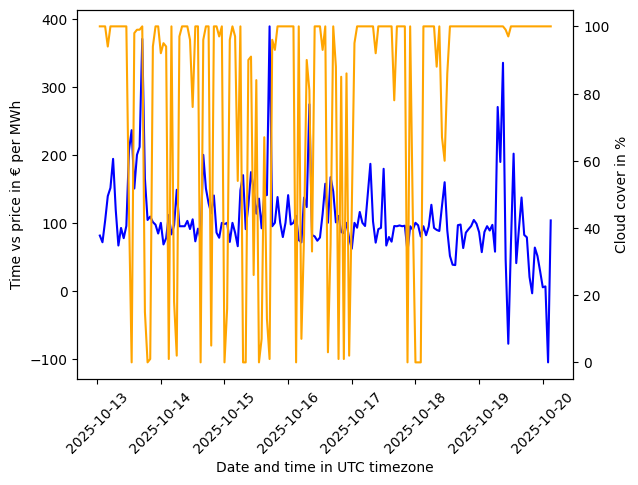

In [71]:
threshold_date = pd.Timestamp('2025-10-13T00:00', tz='UTC')
plot_two_y_series(merge_df[merge_df['datetime_utc'] > threshold_date],
                  x_col='datetime_utc', y1_col='price_eur_mwh', y2_col='cloud_cover (%)', 
                  x_label='Date and time in UTC timezone', y1_label='Time vs price in € per MWh', y2_label='Cloud cover in %')
# --> doesn't seem correlated

In [73]:
merge_df['rain (mm)'].describe()
# 75th percentile is zero, so not really useful

count    49560.000000
mean         0.012776
std          0.087946
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.500000
Name: rain (mm), dtype: float64

In [74]:
merge_df['snowfall (cm)'].describe()
# min and max are zero --> useless feature

count    49560.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: snowfall (cm), dtype: float64

In [76]:
merge_df['snowfall_height (m)'].describe()
# very weird:
# - negative values (for height???)
# - values going up to 4k meters???
# --> probably wrong values?

count    49560.000000
mean      1827.748386
std        993.941266
min       -460.000000
25%       1190.000000
50%       1910.000000
75%       2520.000000
max       4140.000000
Name: snowfall_height (m), dtype: float64

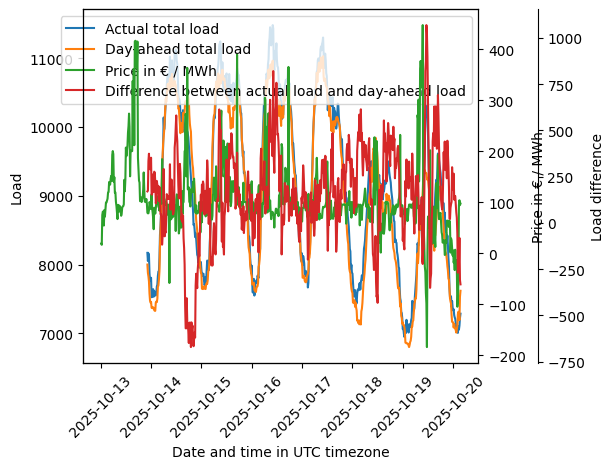

In [79]:
threshold_date = pd.Timestamp('2025-10-13T00:00', tz='UTC')
graph_df = merge_df[merge_df['datetime_utc'] > threshold_date]

x =  graph_df['datetime_utc']
y1 = graph_df['price_eur_mwh']
y2 = graph_df['Actual Total Load (MW)']
y3 = graph_df['Day-ahead Total Load Forecast (MW)']
y4 = y2 - y3

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)

# Left axis: y2 and y3 (same scale)
lns1 = ax1.plot(x, y2, color='C0', label='Actual total load')
lns2 = ax1.plot(x, y3, color='C1', label='Day-ahead total load')
ax1.set_ylabel('Load')
ax1.tick_params(axis='y', colors='black')

# Right axis: y3
ax2 = ax1.twinx()
lns3 = ax2.plot(x, y1, color='C2', label='Price in € / MWh')
ax2.set_ylabel('Price in € / MWh')

# Third axis (offset right): y4
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.15))  # offset the third axis
ax3.spines['right'].set_visible(True)
lns4 = ax3.plot(x, y4, color='C3', label='Difference between actual load and day-ahead load')
ax3.set_ylabel('Load difference')

# Combine legend
lines = lns1 + lns2 + lns3 + lns4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

ax1.set_xlabel('Date and time in UTC timezone')

plt.tight_layout()
plt.show()

In [56]:
merge_df.head()

,datetime_utc,price_eur_mwh,forecasted_price_eur_mwh,temperature_2m (°C),rain (mm),snowfall (cm),snowfall_height (m),sunshine_duration (s),wind_speed_10m (km/h),direct_normal_irradiance (W/m²),direct_normal_irradiance_instant (W/m²),precipitation (mm),weather_code (wmo code),is_day (),relative_humidity_2m (%),surface_pressure (hPa),cloud_cover (%),Actual Total Load (MW),Day-ahead Total Load Forecast (MW),Physical Flow (MW)
0,2024-05-21 22:00:00+00:00,106.39,NaN,13.9,0.0,0.0,2320.0,0.0,10.8,0.0,0.0,0.0,3.0,0.0,94.0,1003.3,100.0,NaN,NaN,NaN
1,2024-05-21 22:15:00+00:00,149.28,NaN,13.9,0.0,0.0,2280.0,0.0,11.3,0.0,0.0,0.0,3.0,0.0,93.0,NaN,NaN,NaN,NaN,NaN
2,2024-05-21 22:30:00+00:00,151.17,NaN,13.8,0.0,0.0,2250.0,0.0,11.8,0.0,0.0,0.0,3.0,0.0,93.0,NaN,NaN,NaN,NaN,NaN
3,2024-05-21 22:45:00+00:00,226.60,NaN,13.6,0.0,0.0,2210.0,0.0,12.3,0.0,0.0,0.0,3.0,0.0,93.0,NaN,NaN,NaN,NaN,NaN
4,2024-05-21 23:00:00+00:00,204.76,NaN,13.5,0.0,0.0,2170.0,0.0,12.2,0.0,0.0,0.0,3.0,0.0,93.0,1002.7,100.0,NaN,NaN,NaN
